# Data Preparations

## Importing Stage

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('../data/ecommerce_data.csv', sep=',', header=0, encoding='latin1')

## Quick Glance

In [8]:
df.head()

,OrderID,CustomerID,ProductID,ProductName,Category,Price,Quantity,OrderDate,DeliveryDate,PaymentMethod
0,NaN,e634dd5e-5fab-454f-a243-94c69574c0b5,APPL-00002,Table,Appliances,200.0,3.0,5/9/2020,NaN,PayPal
1,15bdc4db-66bd-452d-9329-39f8aba917a1,NaN,APPL-00002,Table,Appliances,200.0,10.0,4/2/2021,NaN,Credit Card
2,740adfd3-b104-4b3f-b45e-f029a00410b5,f7bdf6e6-5c46-4adb-86f4-0d966d24d796,INST-00005,Piano,Instruments,5000.0,1.0,12/9/2020,NaN,Cash
3,4827d46d-6459-49a8-bd4c-49f8eebc9c3e,2d716158-ab11-4375-9da1-604afcff037a,ELEC-00001,NaN,Electronics,800.0,3.0,5/8/2022,NaN,PayPal
4,a8adf0b5-0f83-46fe-82d9-a78d8a865288,8348962d-a3be-49a5-b750-d5d13f8e6abc,ELEC-00003,Laptop B,Electronics,2000.0,1.0,7/31/2022,8/8/2022,PayPal


### Detecting Null Data(s)

In [10]:
df.isna().sum()

OrderID           93
CustomerID        74
ProductID         12
ProductName       12
Category           4
Price             14
Quantity          91
OrderDate         92
DeliveryDate     193
PaymentMethod    105
dtype: int64

## Data Cleansing

### Altering Null(s)

In [13]:
def clean_data(df):

    # Create DataFrame
    df = pd.DataFrame(df)
    
    # Cleanse the data
    # Fill missing ProductID
    df["ProductID"] = df["ProductID"].fillna(
        df.groupby("ProductName")["ProductID"].transform("first")
    )
    df["ProductID"] = df["ProductID"].fillna("Unknown-ProductID")
    
    # Fill missing ProductName
    df["ProductName"] = df["ProductName"].fillna(
        df.groupby("ProductID")["ProductName"].transform("first")
    )
    df["ProductName"] = df["ProductName"].fillna("Unknown Product")
    
    # Fill missing Category
    df["Category"] = df["Category"].fillna(
        df.groupby("ProductID")["Category"].transform("first")
    )
    df["Category"] = df["Category"].fillna("Uncategorized")
    
    # Fill missing Price
    df["Price"] = df["Price"].fillna(
        df.groupby("ProductID")["Price"].transform("mean")
    )
    df["Price"] = df["Price"].fillna(
        df.groupby("Category")["Price"].transform("mean")
    )
    df["Price"] = df["Price"].fillna(df["Price"].median())

    #Setting up special cases on some columns
    fill_values = {'PaymentMethod': 'Unknown'}
    for column, value in fill_values.items():
        if column in df.columns:
            df[column] = df[column].fillna(value) #Fill the NAs with values from fill_values
    
    return df


### Applying Cleaned Data

In [15]:
# Apply the cleaning function to your DataFrame and droping NaN Rows on these columns:
df_cleaned = clean_data(df).dropna(subset=["CustomerID", "OrderID", "Quantity", "OrderDate", "DeliveryDate"])

### Verify Data Null(s)

In [17]:
# Verify if the NaN values are handled
print(df_cleaned.isna().sum())

OrderID          0
CustomerID       0
ProductID        0
ProductName      0
Category         0
Price            0
Quantity         0
OrderDate        0
DeliveryDate     0
PaymentMethod    0
dtype: int64


## Output the Cleansed Data

In [19]:
# stored at ../data Folder
df_cleaned.to_csv('../data/ecommerce_data_cleaned.csv', sep=',', encoding='latin1')

# Data Analysis

## Average Price of Sale Products

In [30]:
# Calculate the average price (ignores NaN by default)
average_price = df_cleaned["Price"].mean()

# Print the result
print("Average Price:", average_price)

Average Price: 657.1835443037975


## Highest Quantity of Sales

In [32]:
# Find the highest quantity of sales
highest_quantity = df_cleaned["Quantity"].max()

# Print the result
print("Highest Quantity of Sales:", highest_quantity)

Highest Quantity of Sales: 10.0


## Which Category has the Highest Average Price?

In [34]:
# Group by 'Category' and calculate the average price for each category
avg_price_per_category = df_cleaned.groupby("Category")["Price"].mean()

# Find the category with the highest average price
category_with_highest_avg_price = avg_price_per_category.idxmax()
highest_avg_price = avg_price_per_category.max()

# Print the result
print(f"Category with the highest average price: {category_with_highest_avg_price}")
print(f"Highest average price: {highest_avg_price}")

Category with the highest average price: Instruments
Highest average price: 1656.896551724138


## Monthly Sales Trend

In [36]:
# Step 1: Convert 'OrderDate' to datetime format
df_cleaned['OrderDate'] = pd.to_datetime(df_cleaned['OrderDate'])

# Step 2: Extract Year-Month for grouping
df_cleaned['YearMonth'] = df_cleaned['OrderDate'].dt.to_period('M')

# Step 3: Calculate Total Sales
df_cleaned['TotalSales'] = df_cleaned['Price'] * df_cleaned['Quantity']

# Step 4: Group by 'YearMonth' and calculate monthly sales
monthly_sales = df_cleaned.groupby('YearMonth')['TotalSales'].sum().reset_index()

# Step 5: Compute Month-over-Month (MoM) percentage change
monthly_sales['MoM_Change_Percentage'] = monthly_sales['TotalSales'].pct_change() * 100

# Display the results
print(monthly_sales)

   YearMonth  TotalSales  MoM_Change_Percentage
0    2020-01    100940.0                    NaN
1    2020-02     12550.0             -87.566871
2    2020-03     46980.0             274.342629
3    2020-04     47760.0               1.660281
4    2020-05     66280.0              38.777219
5    2020-06     61430.0              -7.317441
6    2020-07     69160.0              12.583428
7    2020-08     29940.0             -56.709080
8    2020-09     68030.0             127.221109
9    2020-10     27260.0             -59.929443
10   2020-11     54210.0              98.862803
11   2020-12     60090.0              10.846707
12   2021-01     60720.0               1.048427
13   2021-02     78490.0              29.265481
14   2021-03     38870.0             -50.477768
15   2021-04     56010.0              44.095704
16   2021-05     28120.0             -49.794680
17   2021-06     17710.0             -37.019915
18   2021-07     29970.0              69.226426
19   2021-08     17120.0             -42

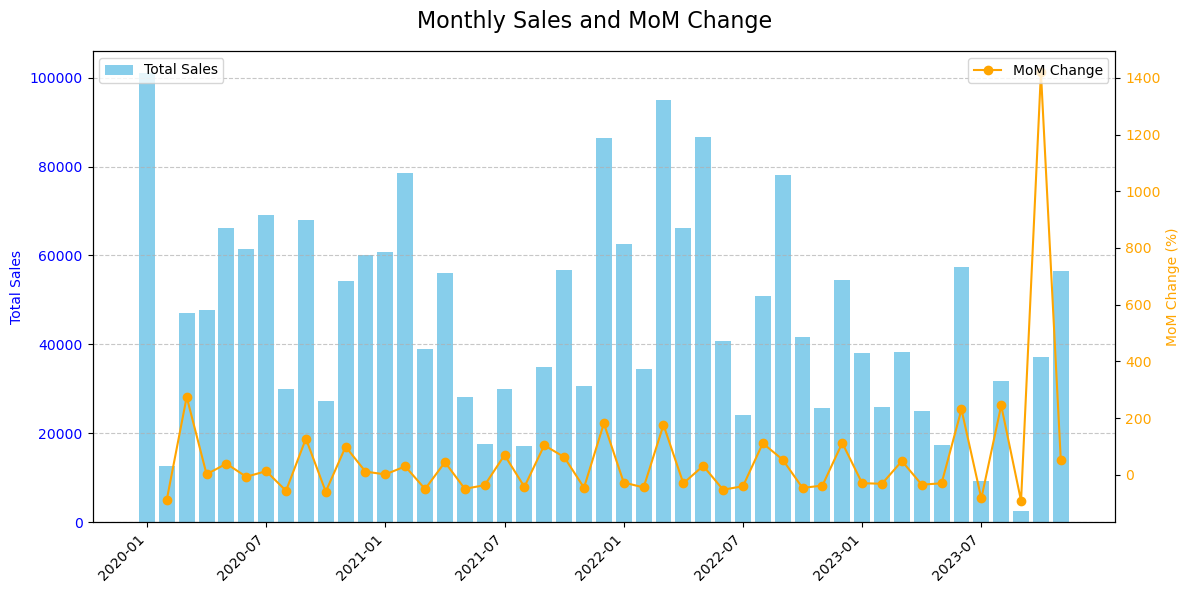

In [37]:
# Convert 'YearMonth' to string for better labeling in the plot
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Sales on the primary y-axis
ax1.bar(monthly_sales['YearMonth'], monthly_sales['TotalSales'], color='skyblue', label='Total Sales')
ax1.set_ylabel('Total Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(monthly_sales['YearMonth'][::6])  # Show every 6th month to avoid clutter
ax1.set_xticklabels(monthly_sales['YearMonth'][::6], rotation=45, ha='right')

# Add a second y-axis for MoM Change
ax2 = ax1.twinx()
ax2.plot(monthly_sales['YearMonth'], monthly_sales['MoM_Change_Percentage'], color='orange', label='MoM Change', marker='o')
ax2.set_ylabel('MoM Change (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and legend
fig.suptitle('Monthly Sales and MoM Change', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show grid lines for readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Is there a certain pattern of sales on certain days of the week?

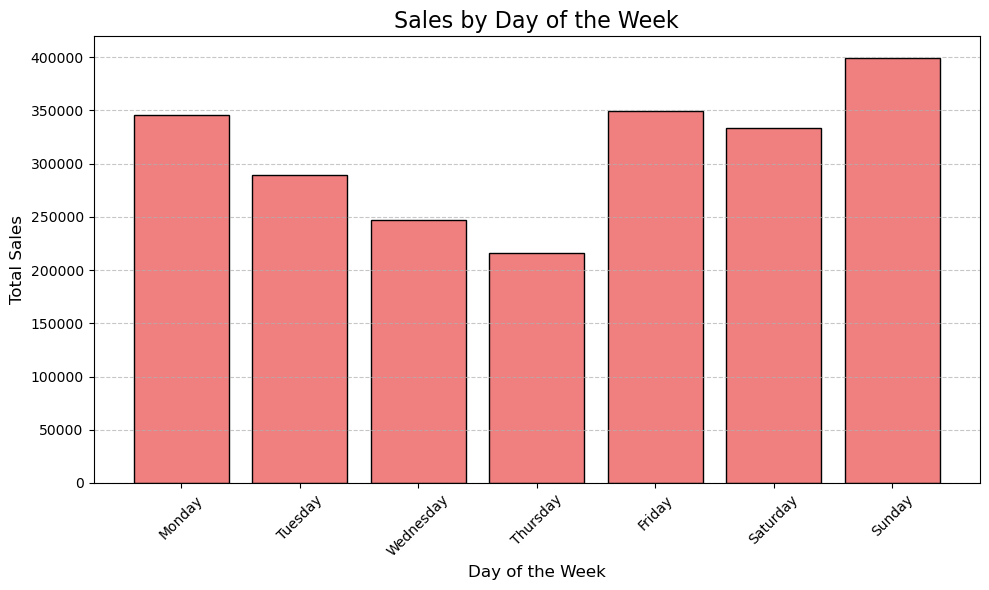

In [39]:
# Step 1: Extract the day of the week from 'OrderDate'
df_cleaned['DayOfWeek'] = df_cleaned['OrderDate'].dt.day_name()

# Step 2: Aggregate sales by day of the week
# Reorder days to follow the standard week sequence
sales_by_day = df_cleaned.groupby('DayOfWeek')['TotalSales'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Step 3: Visualize the sales by day of the week
plt.figure(figsize=(10, 6))
plt.bar(sales_by_day['DayOfWeek'], sales_by_day['TotalSales'], color='lightcoral', edgecolor='black')
plt.title('Sales by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
# It'd seem that Monday, Friday, and Sunday are days with the highest sales regularly, with Sunday being the top of them.

## Distribution of Purchase Quantities per Customer

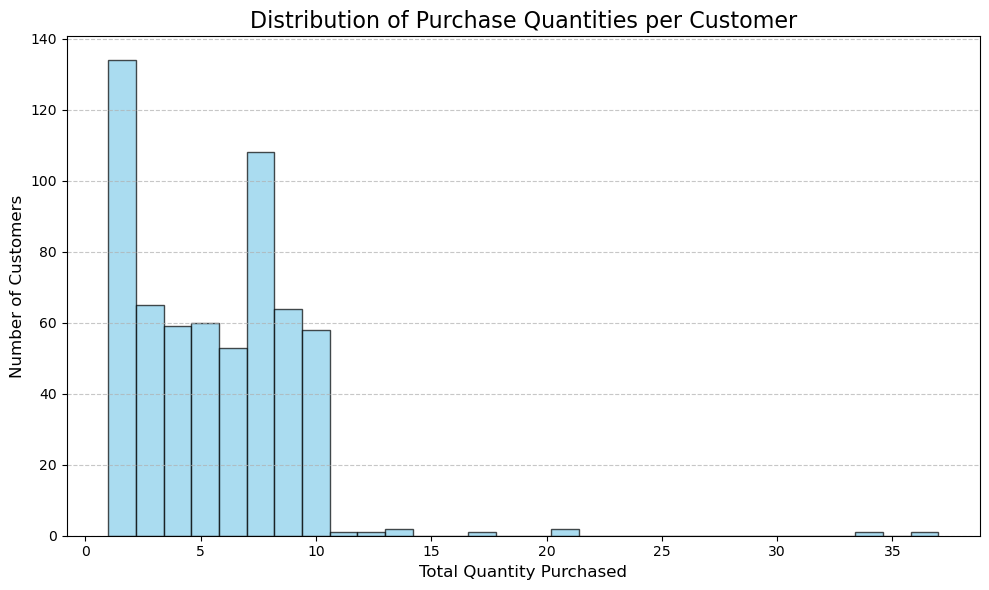

In [42]:
# Step 1: Aggregate quantities per customer
quantities_per_customer = df_cleaned.groupby('CustomerID')['Quantity'].sum().reset_index()

# Step 2: Visualize the distribution
plt.figure(figsize=(10, 6))

# Histogram for distribution
plt.hist(quantities_per_customer['Quantity'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Purchase Quantities per Customer', fontsize=16)
plt.xlabel('Total Quantity Purchased', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Finding Recurring Customers

In [44]:
# Step 1: Group by 'CustomerID' and count the number of purchases
purchase_counts = df_cleaned.groupby('CustomerID').size().reset_index(name='PurchaseCount')

# Step 2: Filter customers who purchase more than once
repeat_customers = purchase_counts[purchase_counts['PurchaseCount'] > 1]

# Display the customers who purchase more than once
print(repeat_customers)


                               CustomerID  PurchaseCount
184  45e58d54-e31e-4185-8ce3-8f00f46595e4              2
199  4de1a022-8ec3-4414-b1e4-de846a55c67c              6
248  605d68a3-3d27-4724-a64c-a4ee131dbaed              4
269  6895d8a2-f8e3-45db-9a5d-594068722090              3
338  82dfa00f-7d38-4c0b-b1b2-b431f31d558e              2
344  855e9c81-b690-4614-8269-f3c520bf4089              3
379  971f0d11-f5c7-482d-be31-90b094007774              5
383  98e02211-5beb-4170-9805-2e24678e9d86              3
520  dd960c6a-f4da-4277-a979-401c2917c0a6              2
556  ea44abe1-48d8-4120-8041-3f853000c86d              2


## Most Frequently Used Payment Method

In [46]:
# Step 1: Group by 'PaymentMethod' and count the occurrences
payment_method_counts = df_cleaned['PaymentMethod'].value_counts()

# Step 2: Identify the most frequent payment method
most_frequent_payment_method = payment_method_counts.idxmax()  # Get the payment method with the highest count
most_frequent_count = payment_method_counts.max()  # Get the highest count

# Display the most frequently used payment method
print(f"The most frequently used payment method is: {most_frequent_payment_method} with {most_frequent_count} occurrences.")


The most frequently used payment method is: Cash with 192 occurrences.


## Is There a Correlation Between Payment Method and Total Spend?

In [48]:
# Step 1: Group by 'PaymentMethod' and calculate total spend
total_spend_by_payment_method = df_cleaned.groupby('PaymentMethod')['TotalSales'].sum().reset_index()

# Step 2: Display the total spend per payment method
print(total_spend_by_payment_method)


  PaymentMethod  TotalSales
0          Cash    741930.0
1   Credit Card    791690.0
2        PayPal    496520.0
3       Unknown    149780.0


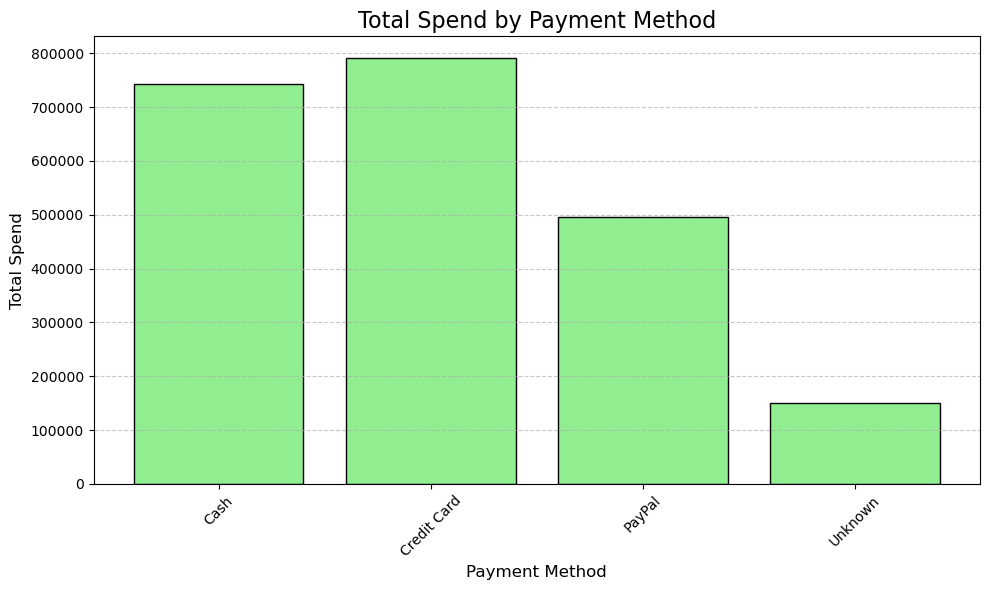

In [49]:
# Step 3: Plot the total spend by payment method
plt.figure(figsize=(10, 6))
plt.bar(total_spend_by_payment_method['PaymentMethod'], total_spend_by_payment_method['TotalSales'], color='lightgreen', edgecolor='black')
plt.title('Total Spend by Payment Method', fontsize=16)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Total Spend', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [50]:
# Step 4: Encode 'PaymentMethod' as categorical data (numerical values)
df_cleaned['PaymentMethodEncoded'] = df_cleaned['PaymentMethod'].astype('category').cat.codes

# Step 5: Compute correlation between the encoded payment method and total sales
correlation = df_cleaned[['PaymentMethodEncoded', 'TotalSales']].corr().iloc[0, 1]

# Display the correlation
print(f"The correlation between payment method and total spend is: {correlation:.2f}")


The correlation between payment method and total spend is: -0.10


In [51]:
# A correlation of -0.10 indicates a very weak negative correlation between the payment method and total spend.

## What is the Percentage of Orders That Experience Delivery Delays? (2 Weeks)

In [53]:
# Step 1: Ensure the dates are in datetime format
df_cleaned['OrderDate'] = pd.to_datetime(df_cleaned['OrderDate'])
df_cleaned['DeliveryDate'] = pd.to_datetime(df_cleaned['DeliveryDate'])

# Step 2: Calculate the delivery delay (in days)
df_cleaned['DeliveryDelay'] = (df_cleaned['DeliveryDate'] - df_cleaned['OrderDate']).dt.days

# Step 3: Identify delayed orders (more than 14 days delay)
delayed_orders = df_cleaned[df_cleaned['DeliveryDelay'] > 14]

# Step 4: Calculate the percentage of delayed orders
total_orders = len(df_cleaned)
delayed_percentage = (len(delayed_orders) / total_orders) * 100

# Display the results
print(f"Total number of orders: {total_orders}")
print(f"Number of orders with delivery delays (more than 2 weeks): {len(delayed_orders)}")
print(f"The percentage of orders with delivery delays (more than 2 weeks) is: {delayed_percentage:.2f}%")


Total number of orders: 632
Number of orders with delivery delays (more than 2 weeks): 5
The percentage of orders with delivery delays (more than 2 weeks) is: 0.79%


## Finding Patterns of Late Delivery based on Product Category

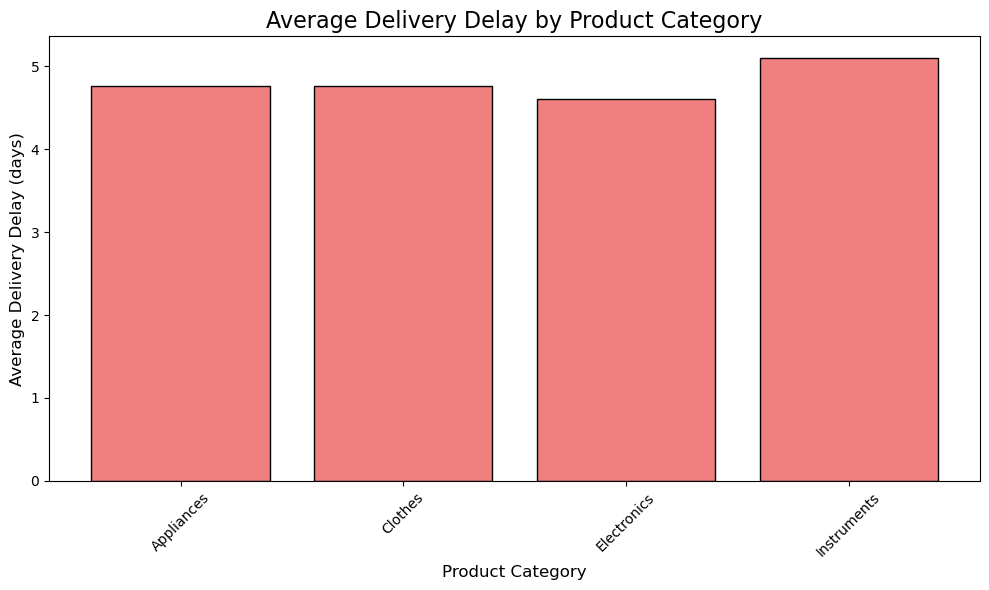

Percentage of delayed orders by product category:
Category
Appliances     0.740741
Clothes        0.689655
Electronics    0.990099
Instruments    0.862069
dtype: float64


In [55]:
# Step 1: Group by 'Category' and calculate the mean delivery delay
category_delay = df_cleaned.groupby('Category')['DeliveryDelay'].mean().reset_index()

# Step 2: Identify the percentage of delayed orders (more than 14 days) for each product category
delayed_by_category = df_cleaned[df_cleaned['DeliveryDelay'] > 14].groupby('Category').size() / df_cleaned.groupby('Category').size() * 100

# Step 3: Plot the average delivery delay by product category
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(category_delay['Category'], category_delay['DeliveryDelay'], color='lightcoral', edgecolor='black')
plt.title('Average Delivery Delay by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Average Delivery Delay (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Display the percentage of delayed orders by product category
print("Percentage of delayed orders by product category:")
print(delayed_by_category)
